In [1]:
import numpy as np
import string
import re
from collections import Counter
import re
from utils import load_file, postprocess_answer_option_conditioned, parse_path
from emoji import emojize
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Any, Tuple, Literal
import os
from functools import partial
from sklearn.metrics import accuracy_score, log_loss

## Metrics

In [2]:
def normalize_answer(s):
    """Lower text and remove punctuation, articles and extra whitespace."""

    def remove_articles(text):
        return re.sub(r'\b(a|an|the)\b', ' ', text)

    def white_space_fix(text):
        return ' '.join(text.split())

    def handle_punc(text):
        exclude = set(string.punctuation + "".join([u"‘", u"’", u"´", u"`"]))
        return ''.join(ch if ch not in exclude else ' ' for ch in text)

    def lower(text):
        return text.lower()

    def replace_underscore(text):
        return text.replace('_', ' ')

    return white_space_fix(remove_articles(handle_punc(lower(replace_underscore(s))))).strip()


def f1_score(prediction, ground_truth):
    '''
    pred: str
    gt: str
    '''
    prediction_tokens = normalize_answer(prediction).split()
    ground_truth_tokens = normalize_answer(ground_truth).split()
    common = Counter(prediction_tokens) & Counter(ground_truth_tokens)
    num_same = sum(common.values())
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(prediction_tokens)
    recall = 1.0 * num_same / len(ground_truth_tokens)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1


def exact_match_score(prediction, ground_truth):
    '''
    pred: str
    gt: str
    '''
    return normalize_answer(prediction) == normalize_answer(ground_truth)


def metric_max_over_ground_truths(metric_fn, prediction, ground_truths):
    '''
    metric_fn: fns that take two strs only
    pred: str
    gts: list(str)
    '''
    if type(ground_truths) == str:
        ground_truths = [ground_truths]
    ground_truths = [i for i in ground_truths if i.strip() != ""]
    scores_for_ground_truths = []
    for ground_truth in ground_truths:
        score = metric_fn(prediction, ground_truth)
        scores_for_ground_truths.append(score)
    return max(scores_for_ground_truths)


# def accuracy(preds, labels):
#     match_count = 0
#     for pred, label in zip(preds, labels):
#         target = label[0]
#         if pred == target:
#             match_count += 1

#     return 100 * (match_count / len(preds))

# def accuracy(pred, label):
#     '''
#     akari claimed acc
#     ===
#     pred: str
#     label: str or list(str)
#     '''
#     if type(label) == list:
#         assert len(label) == 1
#         label = label[0]

#     return pred.lower()==label.lower()

def loose_acc(pred, label):
    '''
    pred: str
    label: str
    '''
    # cnt = 0
    def white_space_fix(text):
        return ' '.join(text.split())

    def handle_punc(text):
        exclude = set(string.punctuation + "".join([u"‘", u"’", u"´", u"`"]))
        return ''.join(ch if ch not in exclude else ' ' for ch in text)

    def lower(text):
        return text.lower()

    pred = white_space_fix(handle_punc(lower(pred))).strip()
    label = white_space_fix(handle_punc(lower(label))).strip()
    if pred == label:
        return 1
    if len(pred) < len(label):
        return 0
    # if pred.startswith(label):
    #     cnt += len(label)

    # return cnt / len(pred)
    if len(pred.split())>0 and pred.split()[0] == label:
        return 1

    return 0

def loose_match(prediction, ground_truth):
    '''
    pred: str
    gt: str
    '''
    if ground_truth in prediction:
        return 1
    return 0

## Scores

In [3]:
def compute_confidence(log_probs:List):
    '''
    log_probs: List[float]
    '''
    return np.mean(log_probs)

def compute_inv_perplexity(log_probs:List):
    '''
    log_probs: List[float]
    '''
    return np.exp(np.mean(log_probs))

In [4]:
def false_invperplexity(ret_ind):
    return np.sum(ret_ind['id_log_probs']) / max(1, len(ret_ind['token_ids']))

def true_invperplexity(ret_ind):
    return np.sum(ret_ind['id_log_probs']) / max(1, len(ret_ind['id_log_probs']))

def recompute_score_inv_perplexity(ret_res, is_selfrag):
    """pass res['retrieval_res']"""
    
    res = ret_res.copy()
    ret_prefix = ['retrieval_0', 'retrieval_1', 'retrieval_2', 'retrieval_3', 'retrieval_4']
    for prefix in ret_prefix:
        if is_selfrag:
            score = ret_res[prefix]['score'] - false_invperplexity(ret_res[prefix]) + true_invperplexity(ret_res[prefix])
        else:
            assert false_invperplexity(ret_res[prefix]) - ret_res[prefix]['score'] < 1e-5
            score = true_invperplexity(ret_res[prefix])
        res[prefix]['score'] = score
    return res
        

In [5]:
def recompute_score(ret_res, recompute_fn, is_closed, is_selfrag):
    ret_res = ret_res.copy()
    for i in ret_res:
        i['retrieval_res'] = recompute_fn(i['retrieval_res'], is_selfrag)
        if is_closed:
            answer2score = {}
            for key, result in i['retrieval_res'].items():
                answer = postprocess_answer_option_conditioned(result["pred"])
                if len(answer.split()) > 0:
                    answer = answer.split()[0]
                score = result["score"]
                answer2score.setdefault(answer, 0)
                answer2score[answer] += score
            sorted_answers = sorted(
                answer2score.items(), key=lambda x: x[1], reverse=True)
            best_option = sorted_answers[0][0]
            hit_results = {key: item for key, item in i['retrieval_res'].items() if postprocess_answer_option_conditioned(item["pred"]).startswith(best_option)}
            
            path2score = {key: item["score"] for key,
                            item in hit_results.items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            i["best_one"] = i['retrieval_res'][best_path]
            best_option = i['retrieval_res'][best_path]["pred"]
            token_ids = i['retrieval_res'][best_path]["token_ids"]
            id_log_probs = i['retrieval_res'][best_path]["id_log_probs"]
        else:
            path2score = {key: item["score"] for key,
                            item in i['retrieval_res'].items()}
            best_path = sorted(path2score.items(),
                                key=lambda x: x[1], reverse=True)[0][0]
            best_option = i['retrieval_res'][best_path]["pred"]
            token_ids = i['retrieval_res'][best_path]["token_ids"]
            id_log_probs =i['retrieval_res'][best_path]["id_log_probs"]
            i["best_one"] = i['retrieval_res'][best_path]
        
        i["retrieval"] = best_option
        i["retrieval_token_ids"] = token_ids
        i["retrieval_log_probs"] = id_log_probs
    return ret_res
        

## Res Analysis

In [6]:
def emo_print(s):
    print(emojize(s))
    
    
emo_print(":bear:")

🐻


In [12]:
class Analyzer:
    def __init__(self, json_path):
        model_name, dataset_name, task, args = parse_path(json_path)
        print('#'*20)
        print(f"#Model: {model_name}|Dataset: {dataset_name}|Task: {task}|Args: {args}")
        # self.metric_evaluation(evaluation_metrics)
        self.model_name = model_name
        self.dataset_name = dataset_name
        self.task = task
        self.args = args
        
        self.dc = self.process_res(json_path)

        self.no_ret_preds = []
        self.use_all_preds = []
        self.select_top_preds = []

    def process_res(self, json_path):
        with open(json_path) as f:
            json_file = json.load(f)
            
            if type(json_file) == list:
                # print(json_file[0].keys())
                # print(json_file[0]['ret_0_scores'].keys())
                res = json_file
            else:
                # print(json_file["results"][0].keys())
                # print(json_file["results"][0]["retrieval_res"].keys())
                res = json_file['results']
                
        if 'ret_0' in res[0]:
            for data in res:
                for i, ret in enumerate(['ret_0', 'ret_1', 'ret_2', 'ret_3', 'ret_4']):
                    assert data["retrieval_res"][f'retrieval_{i}']['pred'] == data[ret]
                    assert data["retrieval_res"][f'retrieval_{i}']['id_log_probs'] == data[ret+'_log_probs']
                    data["retrieval_res"][f'retrieval_{i}']['ctx'] = data[ret+'_ctx']
                    data["retrieval_res"][f'retrieval_{i}']['ctx_score'] = data[ret+'_ctx_score']
                    data["retrieval_res"][f'retrieval_{i}']['scores'] = data[ret+'_scores']
                    
        return res
    
    
    def adp_ret_analysis(self, ret_p, interval=0.01, method=None):
        
        if 'health' in self.dataset_name or 'arc' in self.dataset_name:
            metric = loose_acc
        else:
            metric = loose_match
        
        no_ret_right = [] # if right 1, if wrong 0
        ret_right = [] # if right 1, if wrong 0
        for data_res in self.dc:
            if metric_max_over_ground_truths(metric, data_res['no_retrieval'], data_res['gold']) > 0:
                no_ret_right.append(1)
            else:
                no_ret_right.append(0)
            hit = 0
            for i in range(5):
                if metric_max_over_ground_truths(metric, data_res["retrieval_res"][f'retrieval_{i}']['pred'], data_res['gold']) > 0:
                    hit = 1
                    break
            ret_right.append(hit)
            assert len(no_ret_right) == len(ret_right)
            
        draw_dc = {"retrieval threshold":[], "retrieval freq":[], "self-adaptive acc":[]}
        for thres in [round(interval*i,2) for i in range(0, int(1/interval)+1)]:
            retrieval_freq = np.sum((np.array(ret_p) - thres) > 0) / len(ret_p)
            total_pred = 0
            total_right = 0
            for i, should_ret in enumerate((np.array(ret_p) - thres) > 0):
                # if no_ret_right[i] == ret_right[i]:
                #     continue
                if should_ret and ret_right[i] == 1 and no_ret_right[i] == 0:
                    total_right += 1
                    total_pred += 1
                elif not should_ret and no_ret_right[i] == 1:
                    total_right += 1
                    total_pred += 1
                else:
                    total_pred += 1
            selfadptive_acc = total_right / total_pred
            draw_dc["retrieval threshold"].append(thres)
            draw_dc["retrieval freq"].append(retrieval_freq)
            draw_dc["self-adaptive acc"].append(selfadptive_acc)
        
        draw_dc_ = {}
        draw_dc_["retrieval threshold"] = draw_dc["retrieval threshold"] + draw_dc["retrieval threshold"]
        draw_dc_['metric'] = ['retrieval freq']*len(draw_dc["retrieval freq"]) + ['self-adaptive acc']*len(draw_dc["self-adaptive acc"])
        draw_dc_['value'] = draw_dc["retrieval freq"] + draw_dc["self-adaptive acc"]
        draw_dc_['title'] = [f"{self.model_name} on {self.dataset_name}"]*len(draw_dc_['value'])
        if method is not None:
            draw_dc_['method'] = [method]*len(draw_dc_['value'])
        
        return draw_dc_
    
    def adp_ret_analysis1(self, ret_p, interval=0.01, method=None):
        
        if 'health' in self.dataset_name or 'arc' in self.dataset_name:
            metric = loose_acc
        else:
            metric = loose_match
        acc_point5 = 0
        rf_point5 = 0
        labels = []
        for data_res in self.dc:
            if metric_max_over_ground_truths(metric, data_res['no_retrieval'], data_res['gold']) > 0:
                no_ret_acc = 1
            else:
                no_ret_acc = 0
            hit = 0
            for i in range(5):
                if metric_max_over_ground_truths(metric, data_res["retrieval_res"][f'retrieval_{i}']['pred'], data_res['gold']) > 0:
                    hit = 1
                    break
            ret_acc = hit
            if no_ret_acc > 0:
                labels.append(0)
            else:   
                labels.append(1)
            
        draw_dc = {"retrieval threshold":[], "retrieval freq":[], "self-adaptive acc":[]}
        for thres in [round(interval*i,2) for i in range(0, int(1/interval)+1)]:
            retrieval_freq = np.sum((np.array(ret_p) - thres) > 0) / len(ret_p)
            preds = (np.array(ret_p) - thres) > 0

            selfadptive_acc = accuracy_score(labels, preds)
            if abs(thres - 0.5) < 1e-5:
                acc_point5 = selfadptive_acc
                rf_point5 = round(retrieval_freq*100,1)
                print(f"thres: {thres}, retrieval_freq: {rf_point5}%, selfadptive_acc: {round(selfadptive_acc,2)}")
            draw_dc["retrieval threshold"].append(thres)
            draw_dc["retrieval freq"].append(retrieval_freq)
            draw_dc["self-adaptive acc"].append(selfadptive_acc)
        
        draw_dc_ = {}
        draw_dc_["retrieval threshold"] = draw_dc["retrieval threshold"] + draw_dc["retrieval threshold"]
        draw_dc_['metric'] = ['retrieval freq']*len(draw_dc["retrieval freq"]) + ['self-adaptive acc']*len(draw_dc["self-adaptive acc"])
        draw_dc_['value'] = draw_dc["retrieval freq"] + draw_dc["self-adaptive acc"]
        draw_dc_['title'] = [f"{self.model_name} on {self.dataset_name}"]*len(draw_dc_['value'])
        if method is not None:
            draw_dc_['method'] = [method]*len(draw_dc_['value'])
        print(f"Log loss: {round(log_loss(labels, ret_p),2)}")
        return draw_dc_, f"& {round(acc_point5,2)} & {round(log_loss(labels, ret_p),2)} & {rf_point5}"
    def adp_ret_CFD(self):
            
        if 'health' in self.dataset_name or 'arc' in self.dataset_name:
            metric = loose_acc
        else:
            metric = loose_match
        
        labels = []
        preds = []
        for data_res in self.dc:
            if metric_max_over_ground_truths(metric, data_res['no_retrieval'], data_res['gold']) > 0:
                no_ret_acc = 1
            else:
                no_ret_acc = 0
            if no_ret_acc > 0:
                labels.append(0)
            else:   
                labels.append(1)
        
            no_ret_cfd = compute_confidence(data_res["no_retrieval_log_probs"])
            ret_cfd = []
            for k, v in data_res["retrieval_res"].items():
                ret_cfd.append(compute_confidence(v["id_log_probs"]))
            ret_cfd = np.mean(ret_cfd)
            
            
            preds.append(ret_cfd > no_ret_cfd)
            
        print(f"retrieve_freq: {round(np.sum(preds) / len(preds)*100,1)}%")
        selfadptive_acc = accuracy_score(labels, preds)
        print(f"self-adaptive acc: {round(selfadptive_acc,2)}")
        print(f"Log loss: {round(log_loss(labels, preds),2)}")
        return f"& {round(selfadptive_acc,2)} & {round(log_loss(labels, preds),2)} & {round(np.sum(preds) / len(preds)*100,1)}"

                

        
                    


In [196]:
files_dc = {
    r'post_processed\selfrag-pqa-fullspan.json': r'eval_res\selfrag-pqa-selfadp.json',
    r'post_processed\selfrag-tqa-fullspan.json': r'eval_res\selfrag-tqa-selfadp.json',
    r'post_processed\selfrag-health-fullspan.json': r'eval_res\selfrag-health-selfadp.json',
    r'post_processed\selfrag-arc-fullspan.json': r'eval_res\selfrag-arc-selfadp.json',
    
    r'post_processed\llama2chat-pqa_processed_2mil7.json': r'eval_res\llama2chat-pqa-selfadp.json',
    r'post_processed\llama2chat-tqa_processed_2mil7.json': r'eval_res\llama2chat-tqa-selfadp.json',
    r'post_processed\llama2chat-health_processed_2mil7.json': r'eval_res\llama2chat-health-selfadp.json',
    r'post_processed\llama2chat-arc_processed_2mil7.json': r'eval_res\llama2chat-arc-selfadp.json',
    
    r'post_processed\llama2chat13b-pqa-fullspan.json': r'eval_res\llama2chat13b-pqa-selfadp.json',
    r'post_processed\llama2chat13b-tqa-fullspan.json': r'eval_res\llama2chat13b-tqa-selfadp.json',
    r'post_processed\llama2chat13b-health-fullspan-w_exp.json': r'eval_res\llama2chat13b-health-selfadp.json',
    r'post_processed\llama2chat13b-arc-fullspan-w_exp.json': r'eval_res\llama2chat13b-arc-selfadp.json',
    
    r'post_processed\llama3Ins-pqa_processed_2mil7.json': r'eval_res\llama3Ins-pqa-selfadp.json',
    r'post_processed\llama3Ins-tqa_processed_2mil7.json': r'eval_res\llama3Ins-tqa-selfadp.json',
    r'post_processed\llama3Ins-health_processed_2mil7.json': r'eval_res\llama3Ins-health-selfadp.json',
    r'post_processed\llama3Ins-arc_processed_2mil7.json': r'eval_res\llama3Ins-arc-selfadp.json',
}

In [183]:
cfd_res ={'selfrag': "", 'llama2chat': "", 'llama2chat13b': "", 'llama3Ins': ""}

for key in files_dc:

    a = Analyzer(key)
    temp_res = a.adp_ret_CFD()
    if 'selfrag' in key:
        cfd_res['selfrag'] += temp_res
    elif 'llama2chat-' in key:
        cfd_res['llama2chat'] += temp_res
    elif 'llama2chat13b' in key:
        cfd_res['llama2chat13b'] += temp_res
    elif 'llama3Ins' in key:
        cfd_res['llama3Ins'] += temp_res
for k, v in cfd_res.items():
    print(k, v)

####################
#Model: selfrag|Dataset: pqa|Task: pqa|Args: fullspan
retrieve_freq: 82.0%
self-adaptive acc: 0.71
Log loss: 10.59
####################
#Model: selfrag|Dataset: tqa|Task: tqa|Args: fullspan
retrieve_freq: 81.5%
self-adaptive acc: 0.51
Log loss: 17.69
####################
#Model: selfrag|Dataset: health|Task: fever|Args: fullspan
retrieve_freq: 15.2%
self-adaptive acc: 0.68
Log loss: 11.58
####################
#Model: selfrag|Dataset: arc|Task: arc_c|Args: fullspan
retrieve_freq: 23.6%
self-adaptive acc: 0.71
Log loss: 10.39
####################
#Model: llama2chat|Dataset: pqa|Task: pqa|Args: processed 2mil7
retrieve_freq: 90.2%
self-adaptive acc: 0.76
Log loss: 8.73
####################
#Model: llama2chat|Dataset: tqa|Task: tqa|Args: processed 2mil7
retrieve_freq: 80.9%
self-adaptive acc: 0.48
Log loss: 18.73
####################
#Model: llama2chat|Dataset: health|Task: fever|Args: processed 2mil7
retrieve_freq: 60.2%
self-adaptive acc: 0.45
Log loss: 19.94
#######

In [13]:
# files_dc = {
#     r'eval_res\selfrag-pqa-fullspan.json': r'eval_res\selfragadp-pqa.json',
#     r'eval_res\selfrag-tqa-fullspan.json': r'eval_res\selfragadp-tqa.json',
#     r'eval_res\selfrag-health-fullspan.json': r'eval_res\selfragadp-health.json',
#     r'eval_res\selfrag-arc-fullspan.json': r'eval_res\selfragadp-arc.json',
#     r'eval_res\llama2chat-pqa-fullspan.json': r'eval_res\llama2chat-pqa-selfadp.json',
#     r'eval_res\llama2chat-tqa-fullspan.json': r'eval_res\llama2chat-tqa-selfadp.json',
#     r'eval_res\llama2chat-health-fullspan.json': r'eval_res\llama2chat-health-selfadp.json',
#     r'eval_res\llama2chat-health-fullspan-w_exp.json': r'eval_res\llama2chat-health-selfadp.json',
#     r'eval_res\llama2chat-arc-fullspan.json': r'eval_res\llama2chat-arc-selfadp.json',
#     r'eval_res\llama2chat-arc-fullspan-w_exp.json': r'eval_res\llama2chat-arc-selfadp.json',
#     r'eval_res\llama3Ins-pqa-fullspan.json': r'eval_res\llama3Ins-pqa-selfadp.json',
#     r'eval_res\llama3Ins-tqa-fullspan.json': r'eval_res\llama3Ins-tqa-selfadp.json',
#     r'eval_res\llama3Ins-health-fullspan.json': r'eval_res\llama3Ins-health-selfadp.json',
#     r'eval_res\llama3Ins-health-fullspan-w_exp.json': r'eval_res\llama3Ins-health-selfadp.json',
#     r'eval_res\llama3Ins-arc-fullspan.json': r'eval_res\llama3Ins-arc-selfadp.json',
#     r'eval_res\llama3Ins-arc-fullspan-w_exp.json': r'eval_res\llama3Ins-arc-selfadp.json',
    
# }
files_dc = {
    # r'post_processed\selfrag-pqa-fullspan.json': r'eval_res\selfrag-pqa-selfadp.json',
    # r'post_processed\selfrag-tqa-fullspan.json': r'eval_res\selfrag-tqa-selfadp.json',
    # r'post_processed\selfrag-health-fullspan.json': r'eval_res\selfrag-health-selfadp.json',
    # r'post_processed\selfrag-arc-fullspan.json': r'eval_res\selfrag-arc-selfadp.json',
    r'post_processed\llama2chat-pqa_processed_2mil7.json': r'eval_res\llama2chat-pqa-selfadp.json',
    r'post_processed\llama2chat-tqa_processed_2mil7.json': r'eval_res\llama2chat-tqa-selfadp.json',
    r'post_processed\llama2chat-health_processed_2mil7.json': r'eval_res\llama2chat-health-selfadp.json',
    r'post_processed\llama2chat-arc_processed_2mil7.json': r'eval_res\llama2chat-arc-selfadp.json',
    
    r'eval_res\llama2chat13b-pqa-fullspan.json': r'eval_res\llama2chat13b-pqa-selfadp.json',
    r'eval_res\llama2chat13b-tqa-fullspan.json': r'eval_res\llama2chat13b-tqa-selfadp.json',
    r'eval_res\llama2chat13b-health-fullspan-w_exp.json': r'eval_res\llama2chat13b-health-selfadp.json',
    r'eval_res\llama2chat13b-arc-fullspan-w_exp.json': r'eval_res\llama2chat13b-arc-selfadp.json',
    
    r'post_processed\llama3Ins-pqa_processed_2mil7.json': r'eval_res\llama3Ins-pqa-selfadp.json',
    r'post_processed\llama3Ins-tqa_processed_2mil7.json': r'eval_res\llama3Ins-tqa-selfadp.json',
    r'post_processed\llama3Ins-health_processed_2mil7.json': r'eval_res\llama3Ins-health-selfadp.json',
    r'post_processed\llama3Ins-arc_processed_2mil7.json': r'eval_res\llama3Ins-arc-selfadp.json',
}

In [15]:
out_dcs = []
successful_judgement_2_7 = []
successful_judgement_2_13 = []
successful_judgement_3 = []
res = {'llama2chat': "", 'llama2chat13b': "", 'llama3Ins': "", 'llama2chat2': "", 'llama2chat13b2': "", 'llama3Ins2': ""}
for k, v in files_dc.items():
    print(f"processing {k}, {v}")
    paths = [v, v.replace('selfadp', 'selfadp_v2')]
    for ret_p_path in paths:

        with open(ret_p_path, 'r') as f:
            ret_p_file = json.load(f)
            ret_p = ret_p_file["retrieval_p"]
            ret_p_hard = ret_p_file["retrieval_p_hard"]
        path = k
        analyzer = Analyzer(path)
        successful_judgement = ret_p_file['has_judgment']
        if 'llama2chat-' in analyzer.model_name:
            successful_judgement_2_7.extend(successful_judgement)
        elif 'llama2chat13b' in analyzer.model_name:
            successful_judgement_2_13.extend(successful_judgement)
        else:
            successful_judgement_3.extend(successful_judgement)
        successful_judgement_rate = np.sum(successful_judgement) / len(successful_judgement)
        print(f"successful_judgement_rate: {successful_judgement_rate}")
        out_dc, temp_res = analyzer.adp_ret_analysis1(ret_p, interval=0.01, method='one-shot' if 'v2' in ret_p_path else 'zero-shot')
        if 'v2' in ret_p_path:
            if 'llama2chat-' in k:
                res['llama2chat2'] += temp_res
            elif 'llama2chat13b' in k:
                res['llama2chat13b2'] += temp_res
            elif 'llama3Ins' in k:
                res['llama3Ins2'] += temp_res
        else:
            if 'llama2chat-' in k:
                res['llama2chat'] += temp_res
            elif 'llama2chat13b' in k:
                res['llama2chat13b'] += temp_res
            elif 'llama3Ins' in k:
                res['llama3Ins'] += temp_res
        out_dcs.append(out_dc)
    # plt.show()
print('===finished===')
print("successful_judgement_2_7", np.sum(successful_judgement_2_7) / len(successful_judgement_2_7))
print("successful_judgement_2_13", np.sum(successful_judgement_2_13) / len(successful_judgement_2_13))
print("successful_judgement_3", np.sum(successful_judgement_3) / len(successful_judgement_3))

processing post_processed\llama2chat-pqa_processed_2mil7.json, eval_res\llama2chat-pqa-selfadp.json
####################
#Model: llama2chat|Dataset: pqa|Task: pqa|Args: processed 2mil7
successful_judgement_rate: 1.0
thres: 0.5, retrieval_freq: 94.0%, selfadptive_acc: 0.78
Log loss: 0.63
####################
#Model: llama2chat|Dataset: pqa|Task: pqa|Args: processed 2mil7
successful_judgement_rate: 1.0
thres: 0.5, retrieval_freq: 98.8%, selfadptive_acc: 0.79
Log loss: 1.46
processing post_processed\llama2chat-tqa_processed_2mil7.json, eval_res\llama2chat-tqa-selfadp.json
####################
#Model: llama2chat|Dataset: tqa|Task: tqa|Args: processed 2mil7
successful_judgement_rate: 1.0
thres: 0.5, retrieval_freq: 97.6%, selfadptive_acc: 0.42
Log loss: 3.53
####################
#Model: llama2chat|Dataset: tqa|Task: tqa|Args: processed 2mil7
successful_judgement_rate: 1.0
thres: 0.5, retrieval_freq: 99.4%, selfadptive_acc: 0.43
Log loss: 5.17
processing post_processed\llama2chat-health_proc

C:\Users\22674\AppData\Local\Temp\ipykernel_46620\3307608277.py:44: RuntimeWarning: invalid value encountered in scalar divide
  print("successful_judgement_2_7", np.sum(successful_judgement_2_7) / len(successful_judgement_2_7))


In [189]:
for k, v in res.items():
    print(k, v)

llama2chat & 0.78 & 0.63 & 94.0& 0.42 & 3.53 & 97.6& 0.41 & 2.88 & 79.5& 0.49 & 2.95 & 98.6
llama2chat13b & 0.17 & 3.5 & 0.4& 0.58 & 1.65 & 7.8& 0.64 & 1.18 & 9.4& 0.56 & 2.02 & 6.4
llama3Ins & 0.29 & 1.47 & 19.6& 0.55 & 1.0 & 37.9& 0.69 & 0.61 & 18.4& 0.75 & 0.94 & 1.7
llama2chat2 & 0.79 & 1.46 & 98.8& 0.43 & 5.17 & 99.4& 0.29 & 6.79 & 99.1& 0.49 & 4.97 & 100.0
llama2chat13b2 & 0.69 & 0.95 & 82.7& 0.64 & 0.92 & 37.6& 0.62 & 0.85 & 37.5& 0.51 & 1.25 & 53.1
llama3Ins2 & 0.63 & 0.68 & 67.2& 0.49 & 0.95 & 53.4& 0.41 & 1.07 & 67.6& 0.52 & 0.84 & 37.4


Text(0.5, 0.98, 'Self-adaptive retrieval analysis')

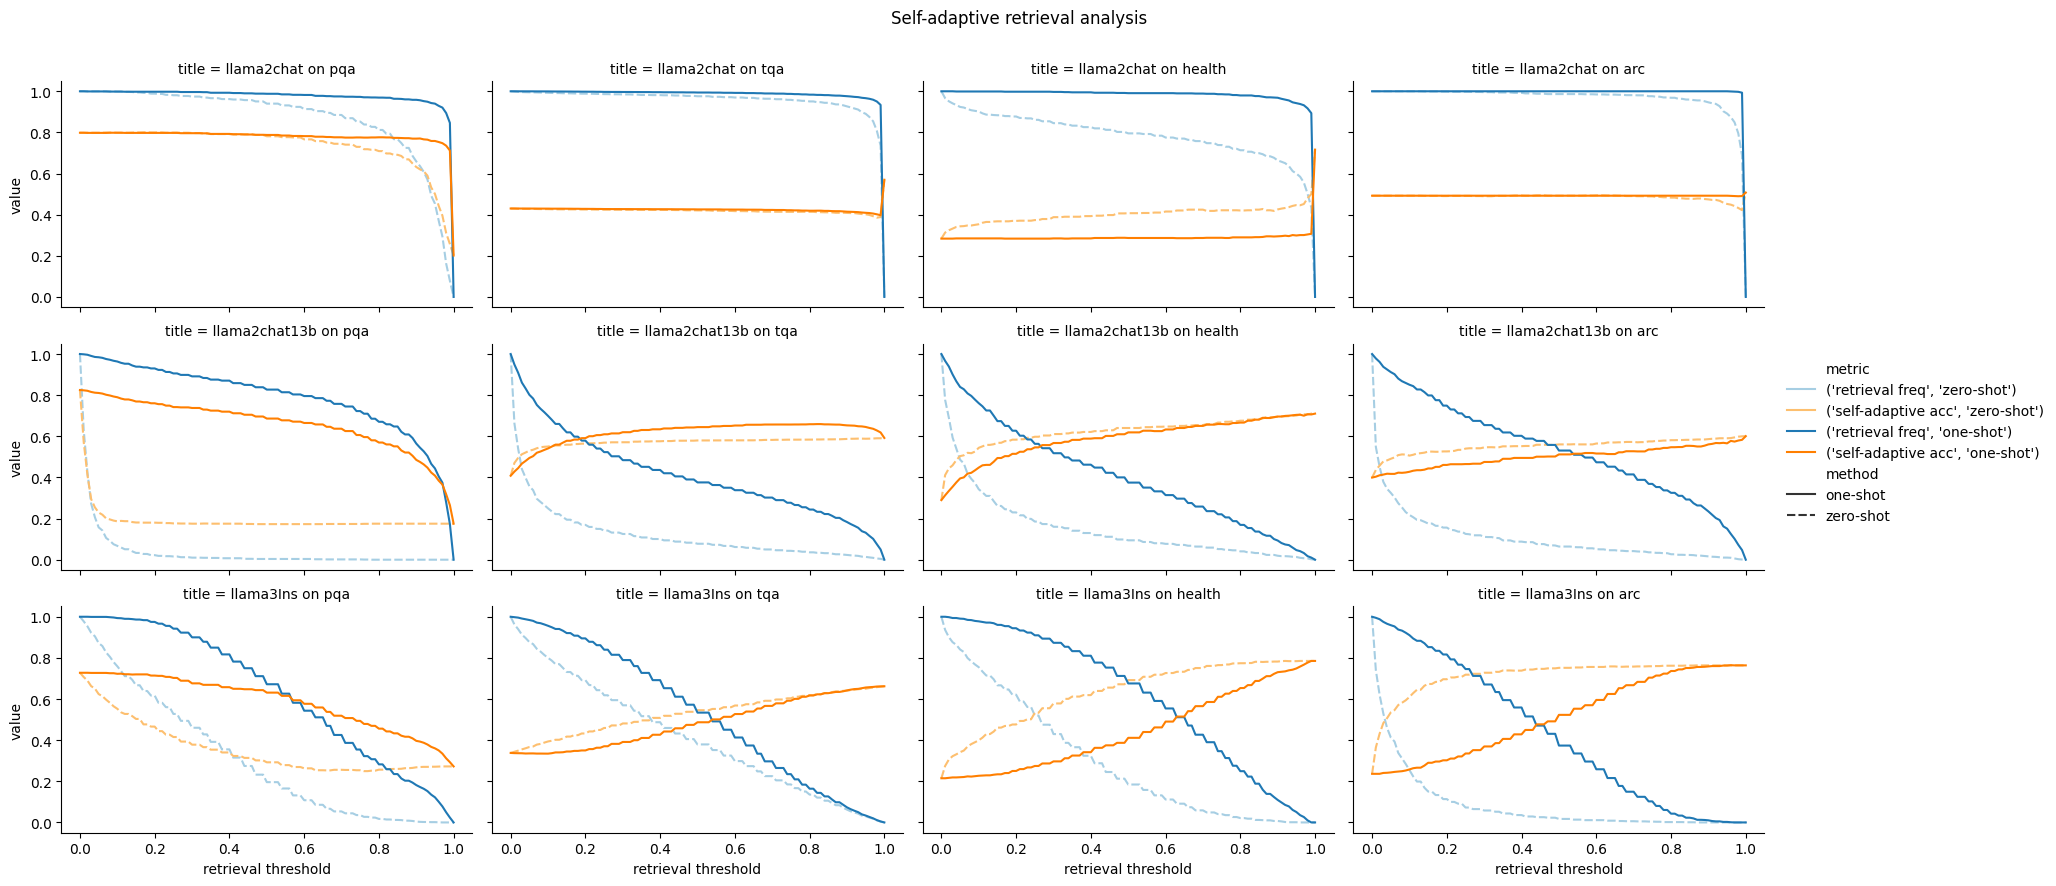

In [16]:
final_dc = {"retrieval threshold":[], "value":[], "title":[], "metric":[], "method":[]}

for dc in out_dcs:
    for k, v in dc.items():
        final_dc[k] += v

df = pd.DataFrame(final_dc)
g = sns.FacetGrid(df, col="title", col_wrap=4,  height=3, aspect=1.5)
if final_dc["method"]:
    g.map(sns.lineplot, "retrieval threshold", "value", hue=df[['metric', 'method']].apply(tuple, axis=1), data=df, sort=False, style='method', style_order=['one-shot', 'zero-shot'], palette = sns.color_palette([sns.color_palette("Paired")[0],sns.color_palette("Paired")[6],sns.color_palette("Paired")[1],sns.color_palette("Paired")[7]]))
else:
    g.map(sns.lineplot, "retrieval threshold", "value", hue="metric", data=df, sort=False)
g.add_legend()
g.legend.texts[0].set_text("metric")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"Self-adaptive retrieval analysis")

In [57]:
g.legend.texts[0].set_text("metric")
g.legend.texts

[Text(0, 0, 'metric'),
 Text(0, 0, "('retrieval freq', 'zero-shot')"),
 Text(0, 0, "('self-adaptive acc', 'zero-shot')"),
 Text(0, 0, "('retrieval freq', 'one-shot')"),
 Text(0, 0, "('self-adaptive acc', 'one-shot')"),
 Text(0, 0, 'method'),
 Text(0, 0, 'one-shot'),
 Text(0, 0, 'zero-shot')]

In [17]:
files_dc = {
    r'eval_res\selfrag-pqa-fullspan.json': r'eval_res\selfrag-pqa-selfadp.json',
    r'eval_res\selfrag-tqa-fullspan.json': r'eval_res\selfrag-tqa-selfadp.json',
    r'eval_res\selfrag-health-fullspan.json': r'eval_res\selfrag-health-selfadp.json',
    r'eval_res\selfrag-arc-fullspan.json': r'eval_res\selfrag-arc-selfadp.json',}

In [18]:
out_dcs = []
selfrag_res = ""
for k, v in files_dc.items():
    ret_p_path = v
    with open(ret_p_path, 'r') as f:
        ret_p_file = json.load(f)
        ret_p = ret_p_file["retrieval_p"]
    path = k
    analyzer = Analyzer(path)
    out_dc, temp_res = analyzer.adp_ret_analysis1(ret_p, interval=0.01)
    out_dcs.append(out_dc)
    selfrag_res += temp_res
    # plt.show()
print(selfrag_res)

####################
#Model: selfrag|Dataset: pqa|Task: pqa|Args: fullspan
thres: 0.5, retrieval_freq: 23.5%, selfadptive_acc: 0.35
Log loss: 0.74
####################
#Model: selfrag|Dataset: tqa|Task: tqa|Args: fullspan
thres: 0.5, retrieval_freq: 12.3%, selfadptive_acc: 0.51
Log loss: 0.7
####################
#Model: selfrag|Dataset: health|Task: fever|Args: fullspan
thres: 0.5, retrieval_freq: 9.0%, selfadptive_acc: 0.68
Log loss: 0.65
####################
#Model: selfrag|Dataset: arc|Task: arc_c|Args: fullspan
thres: 0.5, retrieval_freq: 95.8%, selfadptive_acc: 0.35
Log loss: 0.76
& 0.35 & 0.74 & 23.5& 0.51 & 0.7 & 12.3& 0.68 & 0.65 & 9.0& 0.35 & 0.76 & 95.8


Text(0.5, 0.98, 'SelfRAG adaptive retrieval analysis')

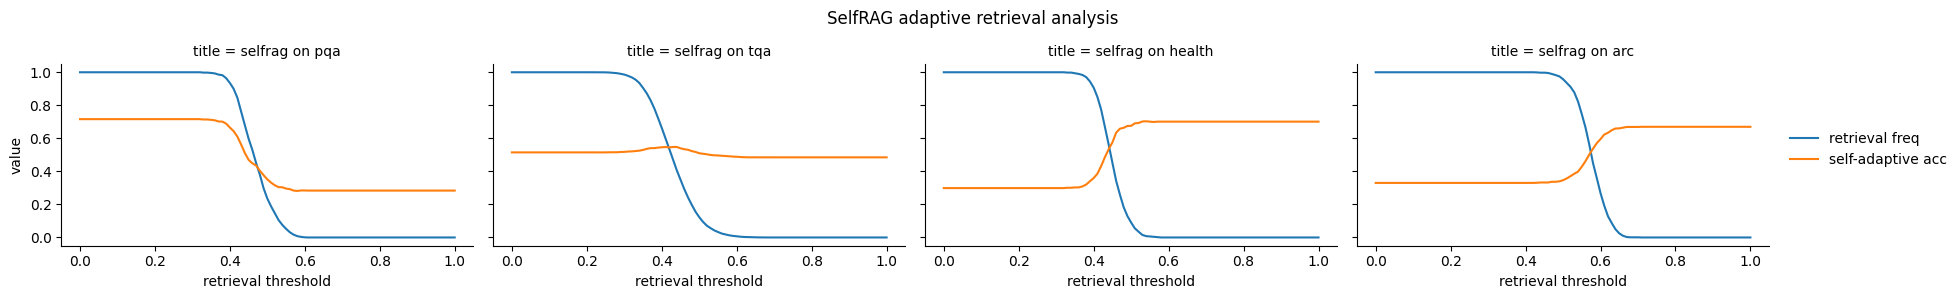

In [140]:
final_dc = {"retrieval threshold":[], "value":[], "title":[], "metric":[]}

for dc in out_dcs:
    for k, v in dc.items():
        try:
            final_dc[k] += v
        except:
            pass

df = pd.DataFrame(final_dc)
g = sns.FacetGrid(df, col="title", col_wrap=4, height=3, aspect=1.5)
g.map(sns.lineplot, "retrieval threshold", "value", hue="metric", data=df, sort=False)
g.add_legend()
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle(f"SelfRAG adaptive retrieval analysis", fontsize=12)